In [1]:
import numpy as np
import numpy.random as npr
import xarray as xr
import matplotlib.pyplot as plt
import dask
import dask.array as da
import h5py
from in_out_formats import v5_inputs, v5_outputs, v5cnv_inputs, v5cnv_outputs, v5cnv_cons_inputs, v5cnv_cons_outputs, v5cnv_cons_qn_inputs, v5cnvqcqi_inputs, v5cnvqcqi_outputs
from glob import glob

In [2]:
EPS = 1e-10

In [3]:
# input_sub = 
# input_div = 
# output_scale = 

norm_path = '/p/project/icon-a-ml/heuer1/ClimSim/preprocessing/normalizations/'

input_mean = xr.open_dataset(norm_path + 'inputs/input_mean_v5_pervar.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max_v5_pervar.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min_v5_pervar.nc')
input_std = xr.open_dataset(norm_path + 'inputs/input_std.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale_std_lowerthred_v5.nc')

In [8]:
# input_mean = input_mean.stack({'batch':{'ncol'}})
# input_mean = input_mean.to_stacked_array('mlvar', sample_dims=['batch'], name=self.input_abbrev)
used_inputs = v5cnvqcqi_inputs#v5_inputs#v5cnv_inputs_nols#
used_outputs = v5cnvqcqi_outputs#v5_outputs#v5cnv_outputs#

input_mean = input_mean[used_inputs].to_stacked_array('mlvar', sample_dims=[])#, name=self.input_abbrev)
input_min = input_min[used_inputs].to_stacked_array('mlvar', sample_dims=[])#, name=self.input_abbrev)
input_max = input_max[used_inputs].to_stacked_array('mlvar', sample_dims=[])#, name=self.input_abbrev)
# input_std = input_std[used_inputs].to_stacked_array('mlvar', sample_dims=[])#, name=self.input_abbrev)
output_scale = output_scale[used_outputs].to_stacked_array('mlvar', sample_dims=[])#, name=self.input_abbrev)

In [9]:
input_mean.values.shape, output_scale.shape

((1096,), (362,))

In [ ]:
# # Create input/output norm
inp_sub = np.loadtxt('/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/preprocessing/normalization/inp_sub.txt')#, delimiter=',')
inp_div = np.loadtxt('/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/preprocessing/normalization/inp_div_qcqifromoutscale.txt')#, delimiter=',')

out_scale = np.loadtxt('/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/preprocessing/normalization/out_scale.txt')#, delimiter=',')
# q_lbd
qn_lbd = np.loadtxt('/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/preprocessing/normalization/qn_exp_lambda_large.txt', delimiter=',')
qc_lbd = np.loadtxt('/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/preprocessing/normalization/qc_exp_lambda_large.txt', delimiter=',')
qi_lbd = np.loadtxt('/work/bd1179/b309215/ClimSimKaggle/leap-climsim-kaggle-5th/preprocessing/normalization/qi_exp_lambda_large.txt', delimiter=',')

inp_sub.shape, inp_div.shape, out_scale.shape, qn_lbd.shape

((1096,), (1096,), (362,), (60,))

In [ ]:
in_data_files = sorted(glob('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_qcqi/**/train_input.zarr', recursive=True))
out_data_files = sorted(glob('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_qcqi/**/train_target.zarr', recursive=True))

In [27]:
import os
test = sorted(os.listdir('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_qcqi/'))
idx_train = test.index('0007-01')+1
idx_val = test.index('0008-01')+1
idx_test = test.index('0009-01')+1
idx_train, idx_val, idx_test

(72, 84, 96)

In [28]:
test[idx_val:idx_test]

['0008-02',
 '0008-03',
 '0008-04',
 '0008-05',
 '0008-06',
 '0008-07',
 '0008-08',
 '0008-09',
 '0008-10',
 '0008-11',
 '0008-12',
 '0009-01']

In [31]:
# in_data = da.concatenate([da.from_zarr(f) for f in in_data_files[:idx_train]], axis=0)
# out_data = da.concatenate([da.from_zarr(f) for f in out_data_files[:idx_train]], axis=0)
# in_data = da.concatenate([da.from_zarr(f) for f in in_data_files[idx_train:idx_val]], axis=0)
# out_data = da.concatenate([da.from_zarr(f) for f in out_data_files[idx_train:idx_val]], axis=0)
in_data = da.concatenate([da.from_zarr(f) for f in in_data_files[idx_val:idx_test]], axis=0)
out_data = da.concatenate([da.from_zarr(f) for f in out_data_files[idx_val:idx_test]], axis=0)

In [32]:
in_data.shape

(36806400, 1096)

In [ ]:
# Climsim
tvt = 'train'

in_data = da.from_zarr(f'/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/{tvt}_input.zarr')
out_data = da.from_zarr(f'/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/{tvt}_target.zarr')

in_data.shape, out_data.shape, in_data.dtype, out_data.dtype

((36806400, 1096), (36806400, 362), dtype('float32'), dtype('float32'))

In [28]:
in_mean_prenorm = da.mean(in_data, axis=0).compute()
in_std_prenorm = da.std(in_data, axis=0).compute()
out_mean_prenorm = da.mean(out_data, axis=0).compute()
out_std_prenorm = da.std(out_data, axis=0).compute()

In [29]:
#do input normalization
# in_data[:,2*60:3*60] = 1 - da.exp(-in_data[:,2*60:3*60] * qn_lbd)
in_data[:,2*60:3*60] = 1 - da.exp(-in_data[:,2*60:3*60] * qc_lbd)
in_data[:,3*60:4*60] = 1 - da.exp(-in_data[:,3*60:4*60] * qi_lbd)
print('a')
# in_data[:,14*60:15*60] = 1 - da.exp(-in_data[:,14*60:15*60] * qn_lbd)
# in_data[:,18*60:19*60] = 1 - da.exp(-in_data[:,18*60:19*60] * qn_lbd)
in_data = (in_data - inp_sub) / inp_div
# in_data = in_data - inp_sub
# print('b')
# in_data = in_data / inp_div
print('a')
in_data = da.where(da.isnan(in_data), 0.0, in_data)
print('a')
in_data = da.where(da.isinf(in_data), 0.0, in_data)
print('a')
#prune top 15 levels in qn input
in_data[:,120:120+15] = 0
in_data[:,180:180+15] = 0
print('a')
#clip rh input
in_data[:,60:120] = da.clip(in_data[:, 60:120], 0, 1.2)

a
a
a
a
a


In [30]:
out_data = out_data * out_scale

In [31]:
in_data = in_data.astype(np.float32)
out_data = out_data.astype(np.float32)
in_data.dtype, out_data.dtype

(dtype('float32'), dtype('float32'))

In [35]:
in_data.shape, out_data.shape

((36806400, 1096), (36806400, 362))

In [36]:
in_mean = da.mean(in_data, axis=0).compute()
in_std = da.std(in_data, axis=0).compute()
out_mean = da.mean(out_data, axis=0).compute()
out_std = da.std(out_data, axis=0).compute()
# in_min = da.min(in_data, axis=0).compute()
# in_max = da.max(in_data, axis=0).compute()

/p/project/icon-a-ml/mambaforge/envs/heuer1_climlab/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/p/project/icon-a-ml/mambaforge/envs/heuer1_climlab/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


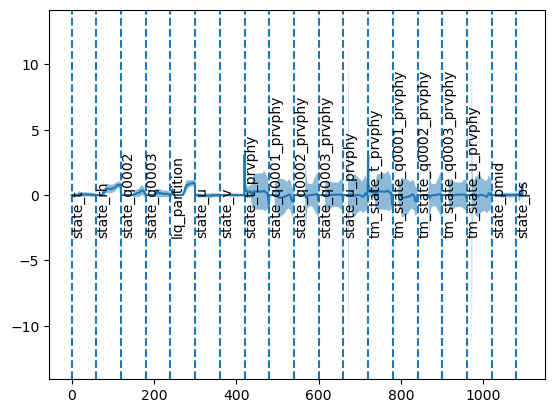

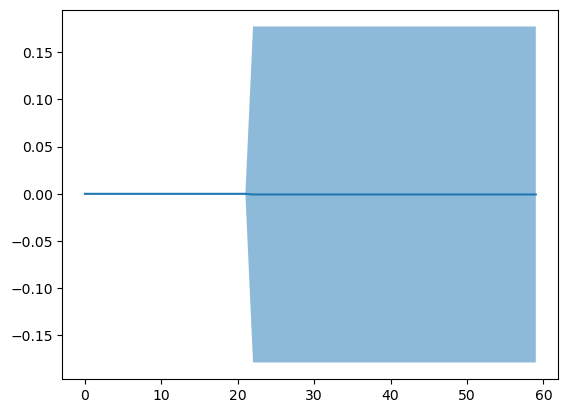

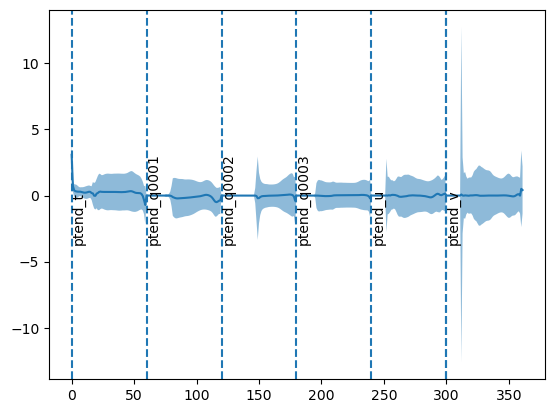

In [38]:
%matplotlib inline
# in_mean = np.mean(in_data, axis=0)
# in_std = np.std(in_data, axis=0)
# out_mean = np.mean(out_data, axis=0)
# out_std = np.std(out_data, axis=0)

plt.figure()#figsize=(15,15))
plt.plot(range(len(in_mean)), in_mean)
plt.fill_between(range(len(in_mean)), in_mean-in_std, in_mean+in_std, alpha=0.5, )

for i in range(len(used_inputs[:-15])):
    plt.axvline(i*60, ls='--')
    plt.text(i*60, -3, used_inputs[i], rotation='vertical')#, transform=plt.gca().transAxes)
plt.axvline(15*60, ls='--')

# plt.ylim(-10,10)
# plt.savefig('../../../figures/input_climsim_meanstd_iconpmid.jpg')#_10-10capped.jpg')
# plt.savefig('../../../figures/input_climsim_meanstd_commonpresnorm.jpg')#_10-10capped.jpg')
# plt.savefig('../../../figures/input_icon_meanstd_aggpresnorm.jpg')#_10-10capped.jpg')
# plt.savefig('../../../figures/input_climsim_meanstd_aggpresnorm.jpg')#_10-10capped.jpg')

plt.figure()
idx0 = 17*60#840#14*60#
idx1 = 18*60#900#15*60#
plt.plot(range(len(in_mean[idx0:idx1])), in_mean[idx0:idx1])
plt.fill_between(range(len(in_mean[idx0:idx1])), (in_mean-in_std)[idx0:idx1], (in_mean+in_std)[idx0:idx1], alpha=0.5, );
# plt.title('P_mid')

# plt.savefig('../../../figures/pmid_climsim_meanstd_iconpmid.jpg')#_10-10capped.jpg')
# plt.savefig('../../../figures/pmid_climsim_meanstd_commonpresnorm.jpg')#_10-10capped.jpg')
# plt.savefig('../../../figures/pmid_icon_meanstd_aggpresnorm.jpg')#_10-10capped.jpg')
# plt.savefig('../../../figures/pmid_climsim_meanstd_aggpresnorm.jpg')#_10-10capped.jpg')

plt.figure()
plt.plot(range(len(out_mean)), out_mean)
plt.fill_between(range(len(out_mean)), out_mean-out_std, out_mean+out_std, alpha=0.5, )

for i in range(len(used_outputs[:-2])):
    plt.axvline(i*60, ls='--')
    plt.text(i*60, -3.5, used_outputs[i], rotation='vertical')
plt.axvline(5*60, ls='--')

# plt.savefig('../../../figures/output_climsim_meanstd.jpg')

plt.show()

# ClimSim

In [40]:
# np.save('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_input_normed.npy', in_data)
# np.save('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed/train_target_normed.npy', out_data)
np.save('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_target_normed_my.npy', out_mean)
np.save('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_target_normed_sy.npy', out_std)
np.save('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_target_my.npy', out_mean_prenorm)
np.save('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_target_sy.npy', out_std_prenorm)

np.save('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_input_normed_4samples.npy', in_data[:4].compute())
np.save('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_target_normed_4samples.npy', out_data[:4].compute())

/p/project/icon-a-ml/mambaforge/envs/heuer1_climlab/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [ ]:
in_data.to_zarr('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_input_nols_normed.zarr')
out_data.to_zarr('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_target_nols_normed.zarr')

npr.seed(8437382)
train_rnd_idx = npr.choice(in_data.shape[0], size=int(5e6), replace=False)
print(train_rnd_idx.shape)
in_sample = in_data[train_rnd_idx,:]
out_sample = out_data[train_rnd_idx,:]

in_sample = in_sample.compute()
out_sample = out_sample.compute()

# 5M
np.save('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_input_nols_normed_5Msample.npy', in_sample)
np.save('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_target_nols_normed_5Msample.npy', out_sample)
# 3M
np.save('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_input_nols_normed_3Msample.npy', in_sample[:int(3e6)])
np.save('/p/scratch/icon-a-ml/heuer1/LEAP/ClimSim_high-res/expandcnv_postprocessed_newqcqi_radfix/train_target_nols_normed_3Msample.npy', out_sample[:int(3e6)])